In [1]:
!conda info --envs

# conda environments:
#
                         /Users/titai/Library/r-miniconda
                         /Users/titai/Library/r-miniconda/envs/r-reticulate
base                     /Users/titai/miniconda3
annovar                  /Users/titai/miniconda3/envs/annovar
bmi7320                  /Users/titai/miniconda3/envs/bmi7320
bs                       /Users/titai/miniconda3/envs/bs
celloracle_py3.9.16      /Users/titai/miniconda3/envs/celloracle_py3.9.16
pcpp                     /Users/titai/miniconda3/envs/pcpp
pyscenic              *  /Users/titai/miniconda3/envs/pyscenic
scvi                     /Users/titai/miniconda3/envs/scvi
seacells                 /Users/titai/miniconda3/envs/seacells
tf                       /Users/titai/miniconda3/envs/tf



In [2]:
import os

import pandas as pd
import numpy as np
import scanpy as sc

import pyscenic
from pyscenic.plotting import plot_binarization
from pyscenic.export import add_scenic_metadata
from pyscenic.cli.utils import load_signatures
from pyscenic.utils import load_motifs
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
from pyscenic.binarization import binarize

import loompy as lp

from MulticoreTSNE import MulticoreTSNE as TSNE

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

import igraph
import louvain

import umap

import json
import zlib
import base64

from scipy.sparse import csr_matrix

import operator as op
from IPython.display import HTML, display

from adjustText import adjust_text

In [3]:
!ls server/

adj_hgsoc_metacells_with_control_20230927.tsv
hgsoc_metacells.h5ad
hgsoc_metacells_regulon_activity_20231005.csv
hgsoc_metacells_with_control_20230927.loom
loom_adata_combined_20230927.loom
loom_adata_combined_20231005.loom
pyscenic_output_hgsoc_metacells_with_control_20230927.loom
reg_hgsoc_metacells_with_control_20230927.csv
tf_gene_name_20231005.csv


In [4]:
#####load the data
adata = sc.read_h5ad('server/hgsoc_metacells.h5ad')    #h5ad file used to create loom file
f_pyscenic_output =  'server/pyscenic_output_hgsoc_metacells_with_control_20230927.loom' #pyscenic_output loomm file
loom_adata_combined = "server/loom_adata_combined_20230927.loom"   #Name loom_adata_xxx.loom
sig = load_signatures('server/reg_hgsoc_metacells_with_control_20230927.csv')    #reg 
df_motifs = load_motifs('server/reg_hgsoc_metacells_with_control_20230927.csv')  #reg
################################################################################ 

# These data were from 182 server

Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [5]:
adata

AnnData object with n_obs × n_vars = 1211 × 35019
    obs: 'GSE_ID', 'GSM_ID', 'Treatment Status', 'Clinical stage', 'Clinical stage (Major)', 'cell_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'GSE_ID_colors', 'Treatment Status_colors', 'cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'raw'
    obsp: 'connectivities', 'distances'

In [6]:
dense = csr_matrix.toarray(adata.X)
adata.X = dense

In [7]:
adata.uns['log1p']['base'] = None

In [8]:
adata

AnnData object with n_obs × n_vars = 1211 × 35019
    obs: 'GSE_ID', 'GSM_ID', 'Treatment Status', 'Clinical stage', 'Clinical stage (Major)', 'cell_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'GSE_ID_colors', 'Treatment Status_colors', 'cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'raw'
    obsp: 'connectivities', 'distances'

In [9]:
# cluster the neighbourhood graph
sc.tl.louvain(adata,resolution=0.4)

In [10]:
# tSNE
tsne = TSNE( n_jobs=20 )
adata.obsm['X_tsne'] = tsne.fit_transform( adata.X )

In [11]:
#adata = adata[adata.obs['cell_type'] != 'unknown']

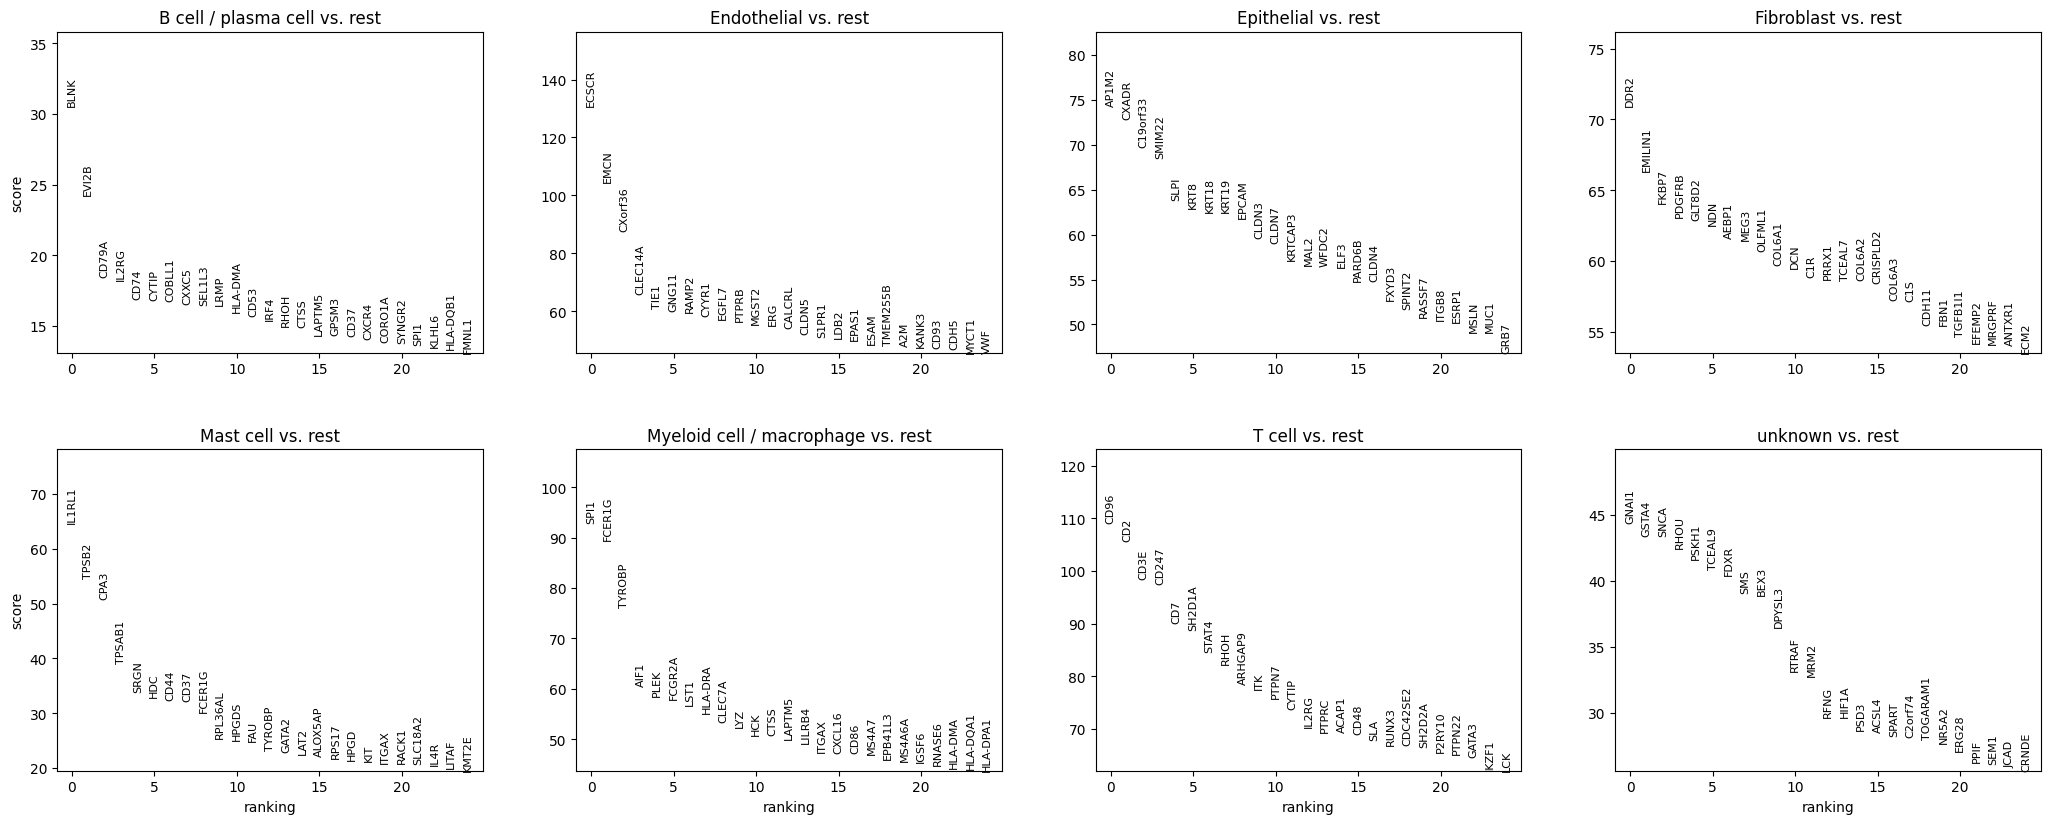

,B cell / plasma cell,Endothelial,Epithelial,Fibroblast,Mast cell,Myeloid cell / macrophage,T cell,unknown
0,BLNK,ECSCR,AP1M2,DDR2,IL1RL1,SPI1,CD96,GNAI1
1,EVI2B,EMCN,CXADR,EMILIN1,TPSB2,FCER1G,CD2,GSTA4
2,CD79A,CXorf36,C19orf33,FKBP7,CPA3,TYROBP,CD3E,SNCA
3,IL2RG,CLEC14A,SMIM22,PDGFRB,TPSAB1,AIF1,CD247,RHOU
4,CD74,TIE1,SLPI,GLT8D2,SRGN,PLEK,CD7,PSKH1
5,CYTIP,GNG11,KRT8,NDN,HDC,FCGR2A,SH2D1A,TCEAL9
6,COBLL1,RAMP2,KRT18,AEBP1,CD44,LST1,STAT4,FDXR
7,CXXC5,CYYR1,KRT19,MEG3,CD37,HLA-DRA,RHOH,SMS
8,SEL1L3,EGFL7,EPCAM,OLFML1,FCER1G,CLEC7A,ARHGAP9,BEX3
9,LRMP,PTPRB,CLDN3,COL6A1,RPL36AL,LYZ,ITK,DPYSL3


In [12]:
# find marker genes
sc.tl.rank_genes_groups(adata, 'cell_type', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

In [13]:
# collect SCENIC AUCell output
lf = lp.connect(f_pyscenic_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [14]:
# UMAP
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_umap.txt", sep='\t')

In [15]:
# tSNE
tsne = TSNE( n_jobs=20 )
dr_tsne = tsne.fit_transform( auc_mtx )
pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_tsne.txt", sep='\t')

# Integrate the output
Here, we combine the results from SCENIC and Scanpy analysis into a SCope-compatible loom file

In [16]:
# scenic output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
#exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID)
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons
dr_umap = pd.read_csv( 'scenic_umap.txt', sep='\t', header=0, index_col=0 )
dr_tsne = pd.read_csv( 'scenic_tsne.txt', sep='\t', header=0, index_col=0 )
###

In [17]:
auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')
regulons.dtype.names = tuple( [ x.replace("(","_(") for x in regulons.dtype.names ] )
# regulon thresholds
rt = meta['regulonThresholds']
for i,x in enumerate(rt):
    tmp = x.get('regulon').replace("(","_(")
    x.update( {'regulon': tmp} )

/var/folders/pf/j04_xfy550scjth9gzy8fxfcst40jb/T/ipykernel_91025/1306291957.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')


In [18]:
tsneDF = pd.DataFrame(adata.obsm['X_tsne'], columns=['_X', '_Y'])

Embeddings_X = pd.DataFrame( index=lf.ca.CellID )
Embeddings_X = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[0] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[0] ,
        dr_tsne['X'] ,
        dr_umap['X']
    ], sort=False, axis=1, join='outer' )
Embeddings_X.columns = ['1','2','3','4']

Embeddings_Y = pd.DataFrame( index=lf.ca.CellID )
Embeddings_Y = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[1] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[1] ,
        dr_tsne['Y'] ,
        dr_umap['Y']
    ], sort=False, axis=1, join='outer' )
Embeddings_Y.columns = ['1','2','3','4']

In [19]:
### metadata
metaJson = {}

metaJson['embeddings'] = [
    {
        "id": -1,
        "name": f"Scanpy t-SNE (highly variable genes)"
    },
    {
        "id": 1,
        "name": f"Scanpy UMAP  (highly variable genes)"
    },
    {
        "id": 2,
        "name": "Scanpy PC1/PC2"
    },
    {
        "id": 3,
        "name": "SCENIC AUC t-SNE"
    },
    {
        "id": 4,
        "name": "SCENIC AUC UMAP"
    },
]

metaJson["clusterings"] = [{
            "id": 0,
            "group": "Scanpy",
            "name": "Scanpy louvain default resolution",
            "clusters": [],
        }]

metaJson["metrics"] = [
        {
            "name": "nUMI"
        }, {
            "name": "nGene"
        }, {
            "name": "Percent_mito"
        }
]

metaJson["annotations"] = [
    {
        "name": "Louvain_clusters_Scanpy",
        "values": list(set( adata.obs['louvain'].astype(str) )) #np.str changed to str
    },
    #{
    #    "name": "Genotype",
    #    "values": list(set(adata.obs['Genotype'].values))
    #},
    #{
    #    "name": "Timepoint",
    #    "values": list(set(adata.obs['Timepoint'].values))
    #},
    #{
    #    "name": "Sample",
    #    "values": list(set(adata.obs['Sample'].values))
    #}
]

# SCENIC regulon thresholds:
metaJson["regulonThresholds"] = rt

for i in range(max(set([int(x) for x in adata.obs['louvain']])) + 1):
    clustDict = {}
    clustDict['id'] = i
    clustDict['description'] = f'Unannotated Cluster {i + 1}'
    metaJson['clusterings'][0]['clusters'].append(clustDict)
    
clusterings = pd.DataFrame()
clusterings["0"] = adata.obs['louvain'].values.astype(np.int64)

In [20]:
def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.values]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    arr = np.array(arr_ip, dtype=dtyp)
    return arr

In [21]:
adata

AnnData object with n_obs × n_vars = 1211 × 35019
    obs: 'GSE_ID', 'GSM_ID', 'Treatment Status', 'Clinical stage', 'Clinical stage (Major)', 'cell_type', 'louvain'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'GSE_ID_colors', 'Treatment Status_colors', 'cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap', 'louvain', 'rank_genes_groups'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_tsne'
    varm: 'PCs'
    layers: 'raw'
    obsp: 'connectivities', 'distances'

In [22]:
adata.obs['cell_type_treatment_status'] = adata.obs['cell_type'].astype(str) + '_'+adata.obs['Treatment Status'].astype(str)

In [23]:
col_attrs = {
    "CellID": np.array(adata.obs.index),
    #"nUMI": np.array(adata.obs['n_counts'].values),
    #"nGene": np.array(adata.obs['n_genes'].values),
    "Louvain_clusters_Scanpy": np.array( adata.obs['louvain'].values ),
    #"Genotype": np.array(adata.obs['Genotype'].values),
    #"Timepoint": np.array(adata.obs['Timepoint'].values),
    #"Sample": np.array(adata.obs['Sample'].values),
    #"Percent_mito": np.array(adata.obs['pct_counts_mt'].values),
    "Embedding": dfToNamedMatrix(tsneDF),
    "Embeddings_X": dfToNamedMatrix(Embeddings_X),
    "Embeddings_Y": dfToNamedMatrix(Embeddings_Y),
    "RegulonsAUC": dfToNamedMatrix(auc_mtx),
    "Clusterings": dfToNamedMatrix(clusterings),
    "ClusterID": np.array(adata.obs['louvain'].values),
    "Celltype_Garnett": np.array(adata.obs["Treatment Status"].values), #I added this manually
    "Celltype": np.array(adata.obs["cell_type"].values), #I added this manually
    "Celltype_Treatment": np.array(adata.obs["cell_type_treatment_status"].values) #I added this manually
}

row_attrs = {
    "Gene": lf.ra.Gene,
    "Regulons": regulons,
}

attrs = {
    "title": "sampleTitle",
    "MetaData": json.dumps(metaJson),
    "Genome": 'hg38',
    "SCopeTreeL1": "",
    "SCopeTreeL2": "",
    "SCopeTreeL3": ""
}

# compress the metadata field:
attrs['MetaData'] = base64.b64encode(zlib.compress(json.dumps(metaJson).encode('ascii'))).decode('ascii')

In [24]:
lp.create(
    filename = loom_adata_combined,
    layers=lf[:,:],
    row_attrs=row_attrs, 
    col_attrs=col_attrs, 
    file_attrs=attrs
)
lf.close() # close original pyscenic loom file

In [25]:
lf.close()

In [26]:
# scenic output
lf = lp.connect(loom_adata_combined, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

In [27]:
# create a dictionary of regulons:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)

In [28]:
# cell annotations from the loom column attributes:
cellAnnot = pd.concat(
    [
        pd.DataFrame( lf.ca.Celltype_Garnett, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.Celltype, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.Celltype_Treatment, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.ClusterID, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.Louvain_clusters_Scanpy, index=lf.ca.CellID ),
        #pd.DataFrame( lf.ca.Percent_mito, index=lf.ca.CellID ),
        #pd.DataFrame( lf.ca.nGene, index=lf.ca.CellID ),
        #pd.DataFrame( lf.ca.nUMI, index=lf.ca.CellID ),
    ],
    axis=1
)
cellAnnot.columns = [
 'Celltype_Garnett', 'Celltype', 'Celltype_Treatment',
 'ClusterID',
 'Louvain_clusters_Scanpy',
 #'Percent_mito',
 #'nGene',
 #'nUMI'
 ]

In [29]:
# capture embeddings:
dr = [
    pd.DataFrame( lf.ca.Embedding, index=lf.ca.CellID )
]
dr_names = [
    meta['embeddings'][0]['name'].replace(" ","_")
]

# add other embeddings
drx = pd.DataFrame( lf.ca.Embeddings_X, index=lf.ca.CellID )
dry = pd.DataFrame( lf.ca.Embeddings_Y, index=lf.ca.CellID )

for i in range( len(drx.columns) ):
    dr.append( pd.concat( [ drx.iloc[:,i], dry.iloc[:,i] ], sort=False, axis=1, join='outer' ))
    dr_names.append( meta['embeddings'][i+1]['name'].replace(" ","_").replace('/','-') )

# rename columns:
for i,x in enumerate( dr ):
    x.columns = ['X','Y']

In [30]:
lf.close()

In [31]:
# drop the embeddings and extra attributes from the obs object
#adata.obs.drop( ['Embedding', 'Embeddings_X', 'Embeddings_Y', 'RegulonsAUC'], axis=1, inplace=True )

In [32]:
#del adata.obs['Embedding']
#del adata.obs['Embeddings_X']
#del adata.obs['Embeddings_Y']
#del adata.obs['RegulonsAUC']

In [33]:
# add the embeddings into the adata.obsm object
for i,x in enumerate( dr ):
    adata.obsm[ 'X_'+dr_names[i] ] = x.values   #as_matrix() -> values

In [34]:
sc._utils.sanitize_anndata( adata ) #utils -> _utils

We can also add all metadata derived from SCENIC to the scanpy.AnnData object.

In [35]:
# load the regulons from a file using the load_signatures function
adata = add_scenic_metadata(adata, auc_mtx, sig)

In [36]:
# helper functions (not yet integrated into pySCENIC):

BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
COLUMN_NAME_LOGO = "MotifLogo"
COLUMN_NAME_MOTIF_ID = "MotifID"
COLUMN_NAME_TARGETS = "TargetGenes"

def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
    """
    :param df:
    :param base_url:
    """
    # Make sure the original dataframe is not altered.
    df = df.copy()
    
    # Add column with URLs to sequence logo.
    def create_url(motif_id):
        return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
    df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
    # Truncate TargetGenes.
    def truncate(col_val):
        return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
    df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
    MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', 200)
    display(HTML(df.head().to_html(escape=False)))
    pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [37]:
#selected_motifs = ['PAX5','TCF3','EBF1']
#df_motifs_sel = df_motifs.iloc[ [ True if x in selected_motifs else False for x in df_motifs.index.get_level_values('TF') ] ,:]

In [38]:
#display_logos(df_motifs.head())
#display_logos( df_motifs_sel.sort_values([('Enrichment','NES')], ascending=False).head(9))

In [39]:
# Compute neighborhood graph
sc.pp.neighbors(adata, use_rep='X_Scanpy_UMAP__(highly_variable_genes)')

# Compute UMAP coordinates
sc.tl.umap(adata, init_pos='X_Scanpy_UMAP__(highly_variable_genes)')

In [40]:
#sc.set_figure_params(frameon=False, dpi=600, fontsize=10, dpi_save=600)

#sc.pl.scatter( adata, basis='umap', 
 #   color=['cell_type','Treatment Status'],
 #   title=['HVG - UMAP (Louvain clusters)','HVG - UMAP (Cell type)'],
 #   alpha=0.8 #,
 #   #save='_Louvain-celltype.pdf'
 #   )

#sc.pl.scatter( adata, basis='X_SCENIC_AUC_UMAP', 
 #   color=['cell_type','Treatment Status'],
 #   title=['SCENIC - UMAP (Louvain clusters)','SCENIC - UMAP (Cell type)'], 
 #   alpha=0.8 #,
    #save='_Louvain-celltype.pdf'
 #   )

In [41]:
auc_mtx

,AHCTF1_(+),AR_(+),ARID3A_(+),ARID5B_(+),ARNT_(+),ATF1_(+),ATF2_(+),ATF3_(+),ATF4_(+),ATF5_(+),...,ZNF629_(+),ZNF740_(+),ZNF75A_(+),ZNF76_(+),ZNF768_(+),ZNF780A_(+),ZNF814_(+),ZNF823_(+),ZNF91_(+),ZSCAN2_(+)
SEACell-0_GSM4568674,0.0,0.000000,0.031915,0.050848,0.025862,0.040891,0.033202,0.036973,0.046400,0.030272,...,0.000000,0.0,0.0,0.011150,0.034270,0.0,0.057778,0.000000,0.021289,0.107143
SEACell-17_GSM4568674,0.0,0.000000,0.026624,0.058525,0.029864,0.041398,0.032185,0.041922,0.044031,0.019116,...,0.000000,0.0,0.0,0.011104,0.034239,0.0,0.056889,0.000000,0.024991,0.121111
SEACell-8_GSM4568674,0.0,0.000000,0.051937,0.043569,0.023636,0.038227,0.029950,0.031260,0.040027,0.037293,...,0.000000,0.0,0.0,0.011176,0.031197,0.0,0.056889,0.000000,0.020800,0.091111
SEACell-16_GSM4568674,0.0,0.000000,0.017270,0.052481,0.027519,0.038419,0.032659,0.038926,0.045577,0.031224,...,0.000000,0.0,0.0,0.012771,0.031394,0.0,0.052825,0.000000,0.022357,0.078730
SEACell-11_GSM4568674,0.0,0.000000,0.045714,0.047935,0.024702,0.038789,0.031911,0.035461,0.041821,0.025279,...,0.000000,0.0,0.0,0.010315,0.030966,0.0,0.057397,0.000000,0.020507,0.105238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEACell-37_GSM6049631,0.0,0.016996,0.032042,0.064368,0.026168,0.038389,0.023117,0.039894,0.046926,0.016163,...,0.009004,0.0,0.0,0.012427,0.023320,0.0,0.048000,0.000000,0.020094,0.075238
SEACell-74_GSM6049631,0.0,0.000000,0.018709,0.043285,0.028086,0.038000,0.026157,0.031214,0.041741,0.035837,...,0.000000,0.0,0.0,0.013593,0.030407,0.0,0.076952,0.000000,0.021858,0.081111
SEACell-4_GSM6049631,0.0,0.000000,0.018032,0.040889,0.027152,0.036758,0.024368,0.028722,0.038745,0.035306,...,0.000000,0.0,0.0,0.013424,0.030037,0.0,0.077587,0.000000,0.021195,0.080476
SEACell-75_GSM6049631,0.0,0.000000,0.048635,0.049125,0.025937,0.036173,0.020176,0.030539,0.047266,0.026884,...,0.000000,0.0,0.0,0.013385,0.024978,0.0,0.053587,0.000000,0.019906,0.078254


In [42]:
rss_cellType = regulon_specificity_scores( auc_mtx, cellAnnot['Celltype'] )
rss_cellType

,AHCTF1_(+),AR_(+),ARID3A_(+),ARID5B_(+),ARNT_(+),ATF1_(+),ATF2_(+),ATF3_(+),ATF4_(+),ATF5_(+),...,ZNF629_(+),ZNF740_(+),ZNF75A_(+),ZNF76_(+),ZNF768_(+),ZNF780A_(+),ZNF814_(+),ZNF823_(+),ZNF91_(+),ZSCAN2_(+)
T cell,0.221713,0.171562,0.394393,0.355823,0.358287,0.373749,0.390739,0.362749,0.360274,0.377749,...,0.213741,0.167445,0.205341,0.357744,0.378662,0.379346,0.366366,0.189506,0.371574,0.378559
Epithelial,0.178609,0.192172,0.296015,0.339495,0.350916,0.354263,0.319339,0.342557,0.337059,0.290513,...,0.216447,0.204544,0.171711,0.361829,0.370399,0.178201,0.384428,0.587999,0.365577,0.351899
Endothelial,0.233360,0.214117,0.212975,0.243846,0.250604,0.244174,0.254585,0.242982,0.245396,0.236352,...,0.212813,0.167445,0.167445,0.251350,0.244616,0.167445,0.251678,0.167445,0.247441,0.242078
Myeloid cell / macrophage,0.207116,0.167445,0.393772,0.277845,0.292554,0.266923,0.281105,0.292846,0.274632,0.437604,...,0.205698,0.167445,0.167445,0.292372,0.275266,0.180478,0.266075,0.167445,0.272816,0.288461
Fibroblast,0.178650,0.365587,0.377573,0.474690,0.447184,0.451508,0.444979,0.455274,0.471775,0.342646,...,0.237192,0.170470,0.167445,0.439482,0.425802,0.169130,0.421669,0.167445,0.438239,0.426720
Mast cell,0.391655,0.176666,0.184233,0.185021,0.183494,0.185332,0.185927,0.183172,0.185790,0.185878,...,0.307195,0.167445,0.167445,0.183558,0.183499,0.167445,0.181671,0.167445,0.183561,0.189540
B cell / plasma cell,0.194912,0.170271,0.215802,0.199720,0.204358,0.206423,0.204182,0.200715,0.204276,0.209944,...,0.177668,0.167445,0.285063,0.199083,0.207069,0.167445,0.204680,0.168676,0.204198,0.212182
unknown,0.167445,0.173269,0.171086,0.173245,0.176311,0.175035,0.174478,0.172915,0.175104,0.170915,...,0.167445,0.167445,0.167445,0.174201,0.176000,0.167445,0.177717,0.167445,0.174594,0.174991


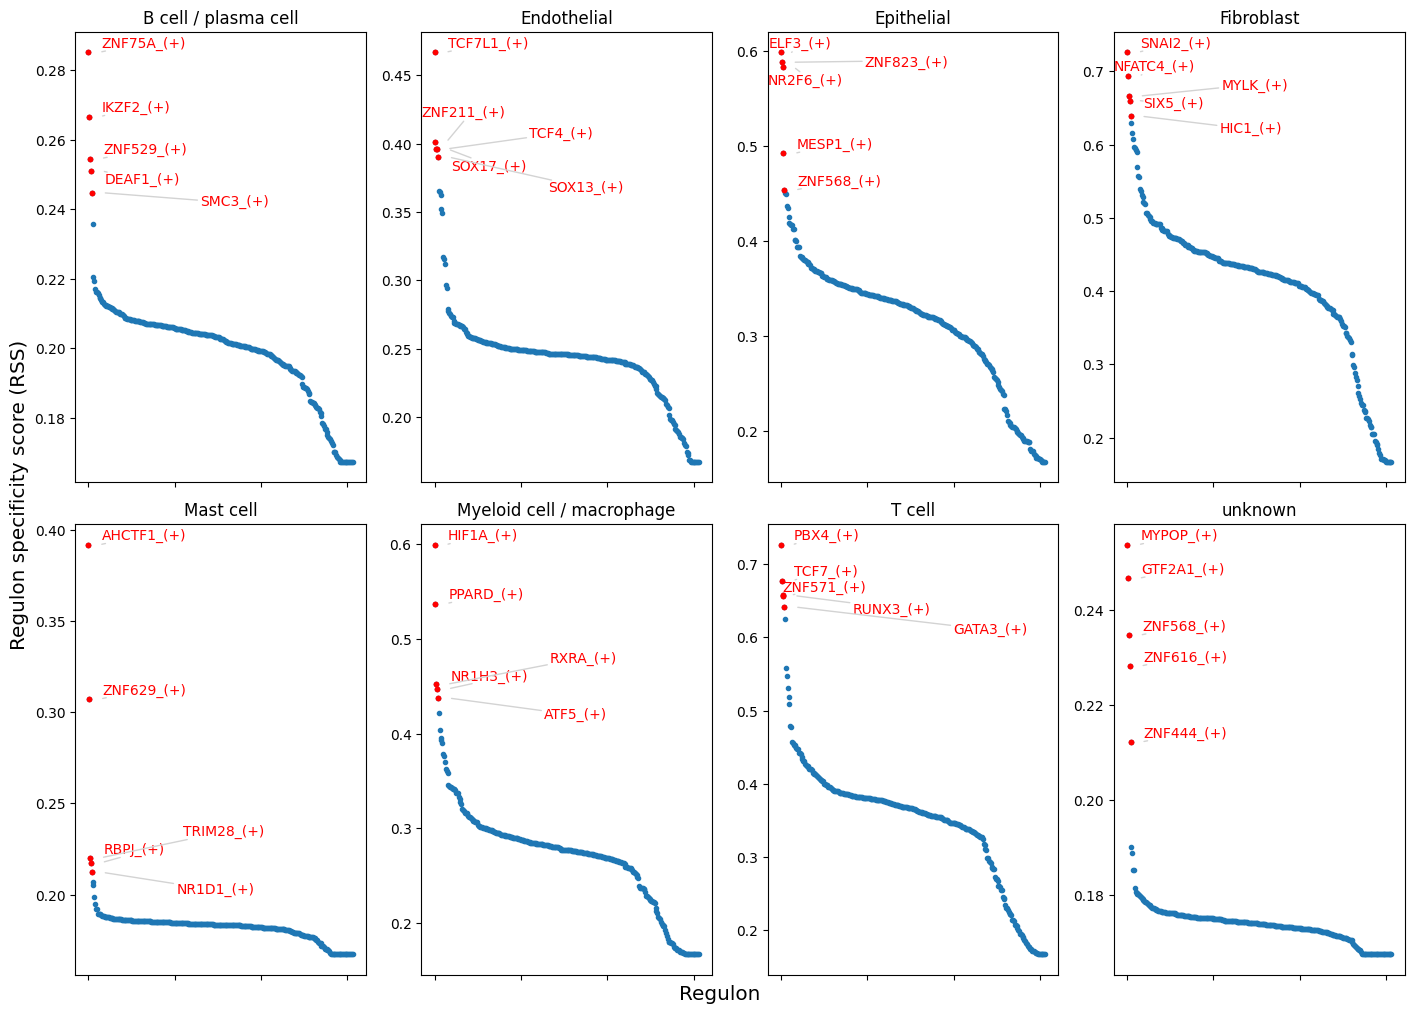

In [43]:
cats = sorted(list(set(cellAnnot['Celltype'])))

fig = plt.figure(figsize=(14, 10))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(2,4,num)
    plot_rss(rss_cellType, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(10)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'medium' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'medium',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
#plt.savefig("PBMC10k_cellType-RSS-top5.pdf", dpi=600, bbox_inches = "tight")
plt.show()

In [44]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

In [45]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)

/var/folders/pf/j04_xfy550scjth9gzy8fxfcst40jb/T/ipykernel_91025/68287874.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
/var/folders/pf/j04_xfy550scjth9gzy8fxfcst40jb/T/ipykernel_91025/68287874.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
/var/folders/pf/j04_xfy550scjth9gzy8fxfcst40jb/T/ipykernel_91025/68287874.py:3: PerformanceWarning: DataFrame is h

In [46]:
auc_mtx_Z

,AHCTF1_(+),AR_(+),ARID3A_(+),ARID5B_(+),ARNT_(+),ATF1_(+),ATF2_(+),ATF3_(+),ATF4_(+),ATF5_(+),...,ZNF629_(+),ZNF740_(+),ZNF75A_(+),ZNF76_(+),ZNF768_(+),ZNF780A_(+),ZNF814_(+),ZNF823_(+),ZNF91_(+),ZSCAN2_(+)
SEACell-0_GSM4568674,-0.202942,-0.298903,-0.314986,0.445349,-0.229169,0.610421,1.389200,0.503052,0.766286,-0.277090,...,-0.283508,-0.063533,-0.087722,-0.786642,0.652236,-0.237271,-0.284268,-0.364692,-0.349649,1.216064
SEACell-17_GSM4568674,-0.202942,-0.298903,-0.521567,1.291223,1.574314,0.728273,1.217638,1.301963,0.427285,-0.633023,...,-0.283508,-0.063533,-0.087722,-0.811669,0.644677,-0.237271,-0.339145,-0.364692,0.855885,1.994025
SEACell-8_GSM4568674,-0.202942,-0.298903,0.466714,-0.356624,-1.232099,-0.008233,0.840681,-0.419169,-0.145864,-0.053113,...,-0.283508,-0.063533,-0.087722,-0.772341,-0.100869,-0.237271,-0.339145,-0.364692,-0.508935,0.323177
SEACell-16_GSM4568674,-0.202942,-0.298903,-0.886801,0.625231,0.517656,0.036421,1.297647,0.818306,0.648552,-0.246706,...,-0.283508,-0.063533,-0.087722,0.107156,-0.052678,-0.237271,-0.590015,-0.364692,-0.001664,-0.366379
SEACell-11_GSM4568674,-0.202942,-0.298903,0.223776,0.124399,-0.751678,0.122337,1.171464,0.259028,0.110905,-0.436392,...,-0.283508,-0.063533,-0.087722,-1.246651,-0.157565,-0.237271,-0.307787,-0.364692,-0.604431,1.109978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEACell-37_GSM6049631,-0.202942,0.347156,-0.310028,1.934996,-0.091266,0.029355,-0.311687,0.974537,0.841583,-0.727215,...,0.781138,-0.063533,-0.087722,-0.082329,-2.031351,-0.237271,-0.887923,-0.364692,-0.738888,-0.560869
SEACell-74_GSM6049631,-0.202942,-0.298903,-0.830612,-0.387943,0.772865,-0.060801,0.201007,-0.426551,0.099511,-0.099558,...,-0.283508,-0.063533,-0.087722,0.560014,-0.294579,-0.237271,0.899523,-0.364692,-0.164388,-0.233772
SEACell-4_GSM6049631,-0.202942,-0.298903,-0.857054,-0.651877,0.351993,-0.349355,-0.100718,-0.828801,-0.329318,-0.116486,...,-0.283508,-0.063533,-0.087722,0.467059,-0.385291,-0.237271,0.938722,-0.364692,-0.380207,-0.269134
SEACell-75_GSM6049631,-0.202942,-0.298903,0.337808,0.255563,-0.195141,-0.485012,-0.807663,-0.535494,0.890295,-0.385172,...,-0.283508,-0.063533,-0.087722,0.445608,-1.625033,-0.237271,-0.542977,-0.364692,-0.800005,-0.392901


In [47]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [48]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot['Celltype'] ]

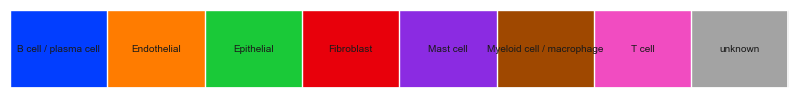

In [49]:
sns.set()
sns.set(font_scale=0.6)
fig = palplot( colors, cats, size=1.0)
#plt.savefig("PBMC10k_cellType-heatmap-legend-top5.pdf", dpi=600, bbox_inches = "tight")

/Users/titai/miniconda3/envs/pyscenic/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


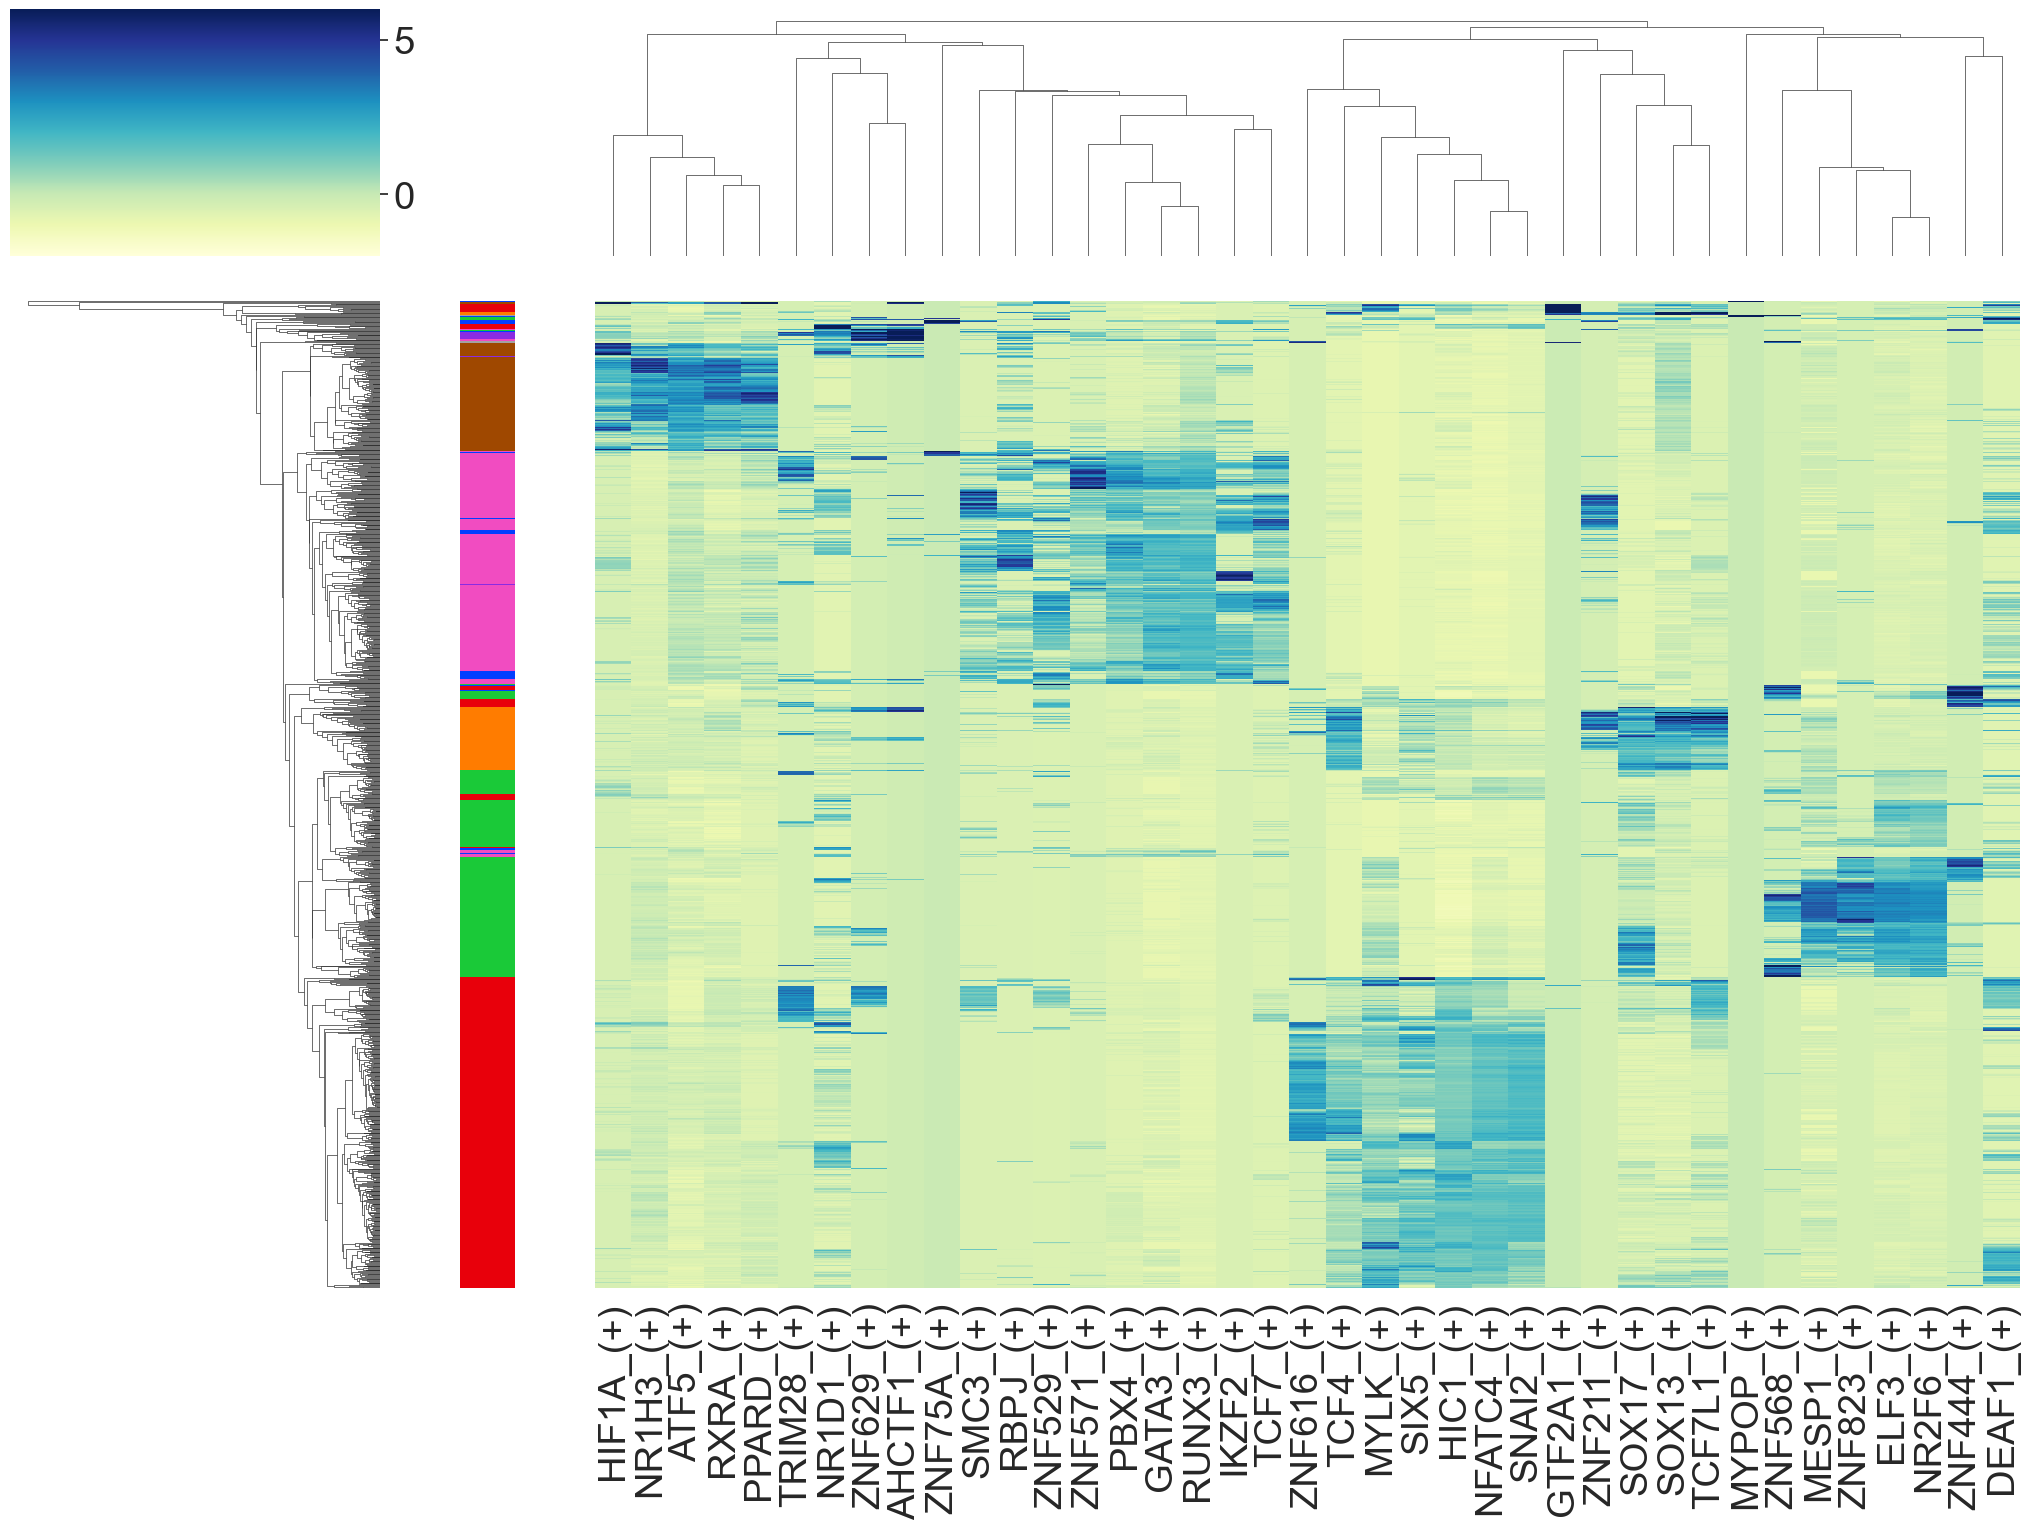

In [55]:
sns.set(font_scale=2.5)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')

plt.savefig("Regulon_in_each_cell_type.png", dpi=600, bbox_inches = "tight")

In [51]:
#binary_mtx, auc_thresholds = binarize( auc_mtx, num_workers=25 )
#binary_mtx.head()

In [52]:
# select regulons:
#r = [ 'RXRA_(+)', 'NFE2_(+)', 'ETV2_(+)' ]

#fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)
#for i,ax in enumerate(axs):
 #   sns.distplot(auc_mtx[ r[i] ], ax=ax, norm_hist=True, bins=100)
  #  ax.plot( [ auc_thresholds[ r[i] ] ]*2, ax.get_ylim(), 'r:')
   # ax.title.set_text( r[i] )
    #ax.set_xlabel('')
    
#fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='large')
#fig.text(0.5, -0.01, 'AUC', ha='center', va='center', rotation='horizontal', size='large')

#fig.tight_layout()
#fig.savefig('PBMC10k_cellType-binaryPlot2.pdf', dpi=600, bbox_inches='tight')

In [53]:
#rss_louvain = regulon_specificity_scores( auc_mtx, cellAnnot['Louvain_clusters_Scanpy'] )
#rss_louvain

In [54]:
adata

AnnData object with n_obs × n_vars = 1211 × 35019
    obs: 'GSE_ID', 'GSM_ID', 'Treatment Status', 'Clinical stage', 'Clinical stage (Major)', 'cell_type', 'louvain', 'cell_type_treatment_status', 'Regulon(AHCTF1_(+))', 'Regulon(AR_(+))', 'Regulon(ARID3A_(+))', 'Regulon(ARID5B_(+))', 'Regulon(ARNT_(+))', 'Regulon(ATF1_(+))', 'Regulon(ATF2_(+))', 'Regulon(ATF3_(+))', 'Regulon(ATF4_(+))', 'Regulon(ATF5_(+))', 'Regulon(ATF6_(+))', 'Regulon(ATF6B_(+))', 'Regulon(BACH1_(+))', 'Regulon(BACH2_(+))', 'Regulon(BATF3_(+))', 'Regulon(BCL3_(+))', 'Regulon(BCL6_(+))', 'Regulon(BCLAF1_(+))', 'Regulon(BDP1_(+))', 'Regulon(BHLHE40_(+))', 'Regulon(BHLHE41_(+))', 'Regulon(BRF1_(+))', 'Regulon(BRF2_(+))', 'Regulon(CEBPB_(+))', 'Regulon(CEBPD_(+))', 'Regulon(CEBPG_(+))', 'Regulon(CEBPZ_(+))', 'Regulon(CERS2_(+))', 'Regulon(CERS6_(+))', 'Regulon(CHD2_(+))', 'Regulon(CLOCK_(+))', 'Regulon(CREB1_(+))', 'Regulon(CREB3_(+))', 'Regulon(CREB3L2_(+))', 'Regulon(CREB5_(+))', 'Regulon(CREBL2_(+))', 'Regulon(CREM_(+